### INIT

In [ ]:
import sys
sys.path.insert(0, "home/fuu/sdb/fac-via-ppg/src")

In [ ]:
import numpy as np
from scipy.io.wavfile import read
import torch
from scipy import signal
from waveglow.denoiser import Denoiser

import torch
# waveglow = torch.hub.load('nvidia/DeepLearningExamples:torchhub', 'nvidia_waveglow')

import IPython.display as ipd

In [ ]:
pwd

'/home/fuu/sdb/fac-via-ppg/test'

In [ ]:
cd /home/fuu/sdb/fac-via-ppg/src/script/

/home/fuu/sdb/fac-via-ppg/src/script


In [ ]:
# generate_synthesis.py [-h] --ppg2mel_model PPG2MEL_MODEL_PATH
#                            --waveglow_model WAVEGLOW_MODEL_PATH
#                            --teacher_utterance_path TEACHER_UTTERANCE_PATH
#                            --output_dir OUTPUT_DIR
#                            --named FILE_NAME

### 0628-Ⅰ P2M 模型检视

#### 0. INIT

In [2]:
import sys 
sys.path.insert(0, "/home/fuu/sdb/fac-via-ppg/src/")

In [79]:
# Library
from ppg import DependenciesPPG
from scipy.io import wavfile
from common import feat
from common import ppg

In [80]:
# Get PPGs
def get_ppg(wav_path, deps):
    fs, wav = wavfile.read(wav_path)
    wave_data = feat.read_wav_kaldi_internal(wav, fs)
    seq = ppg.compute_full_ppg_wrapper(wave_data, deps.nnet, deps.lda, 10)
    return seq

# data to GPU
def to_gpu(x):
    x = x.contiguous()

    if torch.cuda.is_available():
        x = x.cuda(non_blocking=True)
    return torch.autograd.Variable(x)

def get_inference(seq, model, is_clip=False):
    """Tacotron inference.

    Args:
        seq: T*D numpy array.
        model: Tacotron model.
        is_clip: Set to True to avoid the artifacts at the end.

    Returns:
        synthesized mels.
    """
    # (T, D) numpy -> (1, D, T) cpu tensor
    seq = torch.from_numpy(seq).float().transpose(0, 1).unsqueeze(0)
    # cpu tensor -> gpu tensor
    seq = to_gpu(seq)
    mel_outputs, mel_outputs_postnet, _, alignments = model.inference(seq)
    if is_clip:
        return mel_outputs_postnet[:, :, 10:(seq.size(2)-10)]
    else:
        return mel_outputs_postnet

In [82]:
"""
为了不让模型在计算ppg的时候炸掉，直接用抽取好的PPG
抽好的ppg格式是这样的 ppg_sequences.append(ppg_feat_pair[0].astype(np.float32))，get_ppg()抽取后再转换为np.float32

直接计算ppg中的ppg是直接使用get_ppg()抽取，不做其他处理
"""
import pickle
import numpy as np

from common.hparams_628 import create_hparams_stage
from script.train_ppg2mel_628 import load_model
import torch


import matplotlib.pyplot as plt
import librosa.display
import librosa
%matplotlib inline

In [85]:
# 载入预测模型
hparams = create_hparams_stage()
# checkpoint_path_698 = "/home/fuu/sdb/model/fac_base_cmu/p2m_bdl/checkpoint_69800"    # 模型已丢失
checkpoint_path_762 = "/home/fuu/sdb/model/fac_base_cmu/p2m_bdl/checkpoint_76200"
checkpoint_path_1500 = "/home/fuu/sdb/model/fac_base_cmu/p2m_bdl/checkpoint_150000"

# tacotron_model_698 = load_model(hparams)
tacotron_model_762 = load_model(hparams)
tacotron_model_1500 = load_model(hparams)

# tacotron_model_698.load_state_dict(torch.load(checkpoint_path_698)['state_dict'])
tacotron_model_762.load_state_dict(torch.load(checkpoint_path_762)['state_dict'])
tacotron_model_1500.load_state_dict(torch.load(checkpoint_path_1500)['state_dict'])

# _ = tacotron_model_698.eval()
_ = tacotron_model_762.eval()
_ = tacotron_model_1500.eval()

is_clip = False

In [112]:
# Taco class
from common.hparams_628 import create_hparams_stage
from script.train_ppg2mel_628 import load_model
import torch

hparams = create_hparams_stage()
class Taco_Model:
    def __init__(self, model_path, hparams):
        self.path = model_path
        self.hparams = hparams
        self.model = load_model(hparams)
        self.init_model()
    
    def load_dict(self):
        self.model.load_state_dict(torch.load(self.path)['state_dict'])
        
    def eval_model(self):
        _ = self.model.eval()
    
    def init_model(self):
        self.load_dict()
        self.eval_model()

is_clip = False

In [109]:
# Data process with pickle
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

class PPG_via_pickle:
    def __init__(self, fpath, model, index=0, is_clip=False):
        self.fpath = fpath
        self.model = model
        self.index = index
        self.is_clip = is_clip
        with open(fpath, 'rb') as f:
            data = pickle.load(f)
        self.ppg_seq = data[0]
        
        self.ppg = ppg_seq[self.index]
        self.mel = self.process()
        
    def process(self):
#         print("PPG's shape: ", np.shape(self.ppg))
        ac_mel = self.get_inference(self.ppg, self.model, self.is_clip)
        ac_mel_np = ac_mel.cpu().detach().numpy()
#         print("Mel's shape: ", np.shape(ac_mel_np[0]))
        ac_mel_np_re = ac_mel_np[0]
        return ac_mel_np_re
        
    def get_inference(self, seq, model, is_clip=False):
        # (T, D) numpy -> (1, D, T) cpu tensor
        seq = torch.from_numpy(seq).float().transpose(0, 1).unsqueeze(0)
        # cpu tensor -> gpu tensor
        seq = to_gpu(seq)
        mel_outputs, mel_outputs_postnet, _, alignments = model.inference(seq)
        if is_clip:
            return mel_outputs_postnet[:, :, 10:(seq.size(2)-10)]
        else:
            return mel_outputs_postnet
        
    def plot_mel(self):
        plt.subplots(figsize=(15,3))
        sns.heatmap(self.mel[::-1], cmap='viridis')
        plt.show()

In [ ]:
# Data process with pickle
from ppg import DependenciesPPG
from scipy.io import wavfile
from common import feat
from common import ppg

deps = DependenciesPPG()
class PPG_via_wav：
    def __init__(self, deps, wpath):
        self.wpath = wpath
        self.deps = deps
        self.ppg = get_ppg()
        
    def get_ppg(self):
        fs, wav = wavfile.read(self.wpath)
        wave_data = feat.read_wav_kaldi_internal(wav, fs)
        seq = ppg.compute_full_ppg_wrapper(wave_data, deps.nnet, deps.lda, 10)
        return seq
    
    def

In [ ]:
# 1. 计算ppg
deps = DependenciesPPG()
teacher_utt_path = "/home/fuu/sdb/fac-via-ppg/data/cmu_us_bdl_arctic/wav/arctic_b0532.wav"
teacher_ppg_cal = get_ppg(teacher_utt_path, deps)

# mel from model
mel_ac_cal = get_inference(teacher_ppg_cal, tacotron_model, is_clip)
mel_ac_cal_S_0 = mel_ac_cal.cpu().detach().numpy()[0]
mel_ac_cal_tS_0 = mel_ac_cal_S_0[::-1]
np.shape(mel_ac_cal_tS_0)

# mel from STFT
mel_au_cal, sr = librosa.load(teacher_utt_path, sr=16000)
mel_au_cal_S_1 = librosa.feature.melspectrogram(mel_au_cal, sr=sr, n_fft=1024, hop_length=160, n_mels=80)
mel_au_cal_logS_1 = librosa.power_to_db(abs(mel_au_cal_S_1[::-1]))
np.shape(mel_au_cal_logS_1)

mel_ac_cal_n = (mel_ac_cal_tS_0-np.min(mel_ac_cal_tS_0))/(np.max(mel_ac_cal_tS_0)-np.min(mel_ac_cal_tS_0))
np.shape(mel_ac_cal_n)

# model
plt.subplots(figsize=(15,3))
sns.heatmap(mel_ac_cal_n, cmap='viridis')

plt.show()

mel_au_cal_n = (mel_au_cal_logS_1-np.min(mel_au_cal_logS_1))/(np.max(mel_au_cal_logS_1)-np.min(mel_au_cal_logS_1))
np.shape(mel_au_cal_n)

# STFT
plt.subplots(figsize=(15,3))
sns.heatmap(mel_au_cal_n, cmap='viridis')

plt.show()

PPG's shape:  (139, 5816)
Mel's shape:  (80, 139)


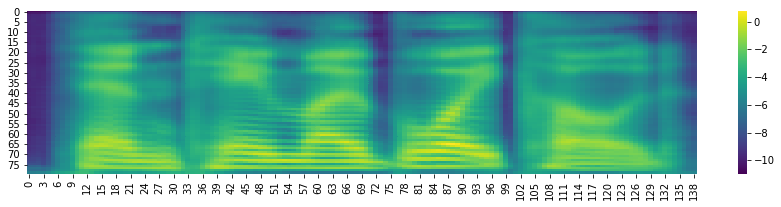

In [107]:

hparams = create_hparams_stage()
# fpath = "/home/fuu/sdb/fac-via-ppg/data/ppgmel_path/bdl_val/file_20_1.txt"
fpath = "/home/fuu/sdb/data/cmu/ppg_mel_pair/bdl_val/file_20_1.txt"
mpath = "/home/fuu/sdb/model/fac_base_cmu/p2m_bdl/checkpoint_109800"

m1098 = Taco_Model(mpath, hparams)
pp = PPG_via_pickle(fpath, m1098.model)
pp.plot_mel()

In [106]:
def once_test_mel(hp, fp, mp):
    print("Checkpoint is ", mp.split(sep="checkpoint_")[1])
    tm = Taco_Model(mp, hp)
    pp = PPG_via_pickle(fp, tm.model)
    pp.plot_mel()

Checkpoint is  109800
PPG's shape:  (139, 5816)
Mel's shape:  (80, 140)


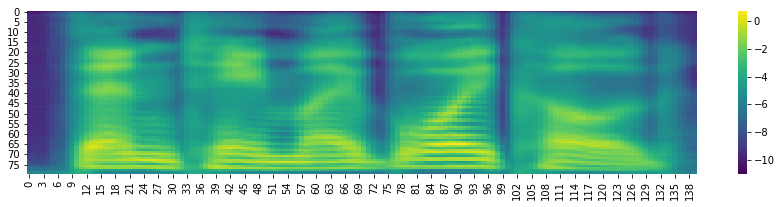

In [108]:
once_test_mel(hparams, fpath, mpath)

In [ ]:
def plot_melspectrogram(S):
        """画出Mel谱"""
#         hop_length = 160
#         S = librosa.feature.melspectrogram(au, sr=self.sr, n_fft=4096, hop_length=hop_length)
        logS = librosa.power_to_db(abs(S))

        plt.figure(figsize=(15, 5))
        librosa.display.specshow(logS, sr=sr, hop_length=160, x_axis='time', y_axis='mel')
        plt.colorbar(format='%+2.0f dB')

#### 1. 用抽取好的ppg
会找不到对应的音频

In [ ]:
# 1. 不计算ppg 0628
ppg_seq = []
fpath = "/home/fuu/sdb/fac-via-ppg/data/ppgmel_path/bdl_val/file_20_1.txt"
# fpath = "/home/fuu/sdb/data/cmu/ppg_mel_pair/bdl_val/file_20_1.txt"

with open(fpath, 'rb') as f:
    data = pickle.load(f)
    ppg_seq = data[0]

teacher_ppg = ppg_seq[1]
# for i in ppg_seq:
#     print(np.shape(i))
print(np.shape(teacher_ppg))

(263, 5816)


In [86]:
# 1. 不计算ppg 0709
ppg_seq = []
# fpath = "/home/fuu/sdb/fac-via-ppg/data/ppgmel_path/bdl_val/file_20_1.txt"
fpath = "/home/fuu/sdb/data/cmu/ppg_mel_pair/bdl_val/file_20_1.txt"

with open(fpath, 'rb') as f:
    data = pickle.load(f)
    ppg_seq = data[0]

teacher_ppg = ppg_seq[1]
# for i in ppg_seq:
#     print(np.shape(i))
print(np.shape(teacher_ppg))

(263, 5816)


In [ ]:
ac_mel = get_inference(teacher_ppg, tacotron_model, is_clip)

In [ ]:
ac_mel_np = ac_mel.cpu().detach().numpy()

In [ ]:
np.shape(ac_mel_np[0])

(80, 264)

In [ ]:
ac_mel_np_re = ac_mel_np[0]

In [91]:
import seaborn as sns
import pandas as pd
import numpy as np

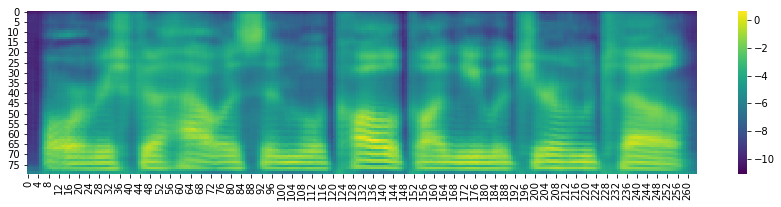

In [ ]:
# logS_0 = librosa.power_to_db(abs(S_0[::-1]))
# 生成的mel不需要power_to_db

plt.subplots(figsize=(15,3))
sns.heatmap(S_0[::-1], cmap='viridis')

plt.show()
plt.close()

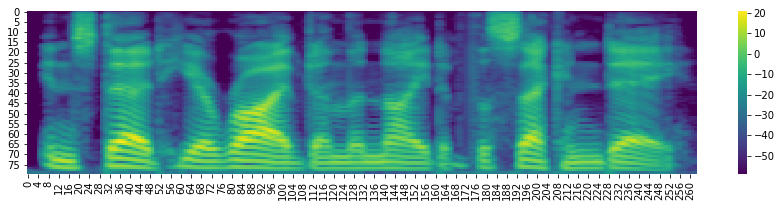

In [ ]:
logS_1 = librosa.power_to_db(abs(S_1[::-1]))

plt.subplots(figsize=(15,3))
sns.heatmap(logS_1, cmap='viridis')

plt.show()
plt.close()

##### 0709

In [87]:
ac_mel_762 = get_inference(teacher_ppg, tacotron_model_762, is_clip)
ac_mel_1500 = get_inference(teacher_ppg, tacotron_model_1500, is_clip)

In [88]:
ac_mel_np_762 = ac_mel_762.cpu().detach().numpy()
ac_mel_np_1500 = ac_mel_1500.cpu().detach().numpy()

In [89]:
np.shape(ac_mel_np_762[0])

(80, 262)

In [90]:
ac_mel_np_re_762 = ac_mel_np_762[0]
ac_mel_np_re_1500 = ac_mel_np_1500[0]

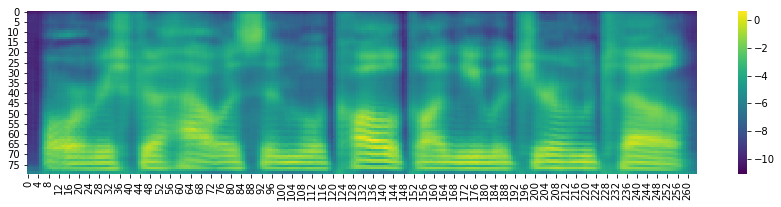

In [ ]:
# logS_0 = librosa.power_to_db(abs(S_0[::-1]))
# 生成的mel不需要power_to_db
# 69800 已丢失

plt.subplots(figsize=(15,3))
sns.heatmap(S_0[::-1], cmap='viridis')

plt.show()
plt.close()

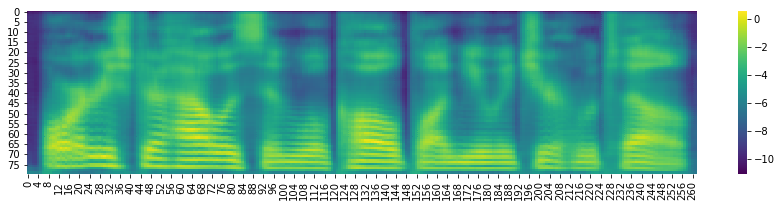

In [92]:
# 76200

plt.subplots(figsize=(15,3))
sns.heatmap(ac_mel_np_re_762[::-1], cmap='viridis')

plt.show()
plt.close()

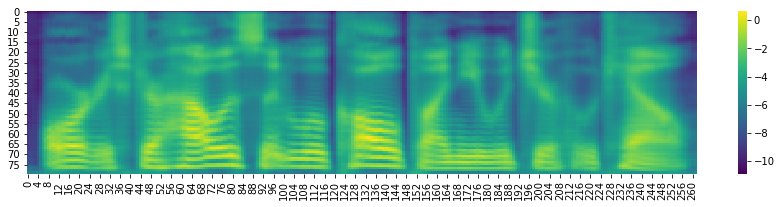

In [93]:
# 150000

plt.subplots(figsize=(15,3))
sns.heatmap(ac_mel_np_re_1500[::-1], cmap='viridis')

plt.show()
plt.close()

##### 0710

Checkpoint is  75800


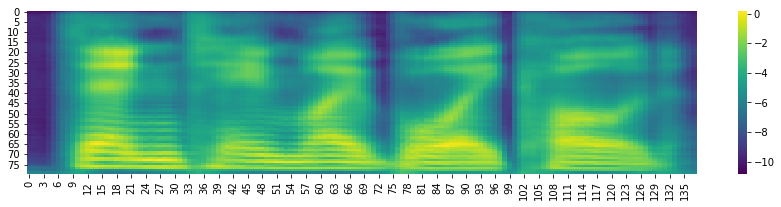

Checkpoint is  83400


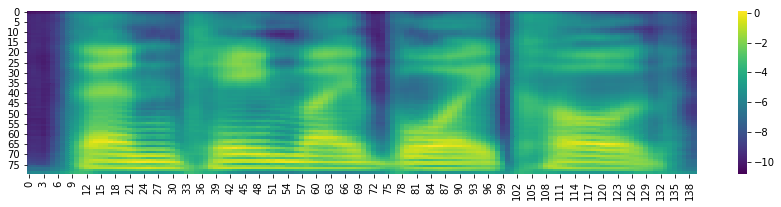

Checkpoint is  92000


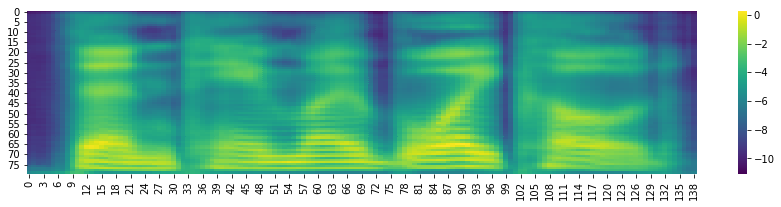

Checkpoint is  104000


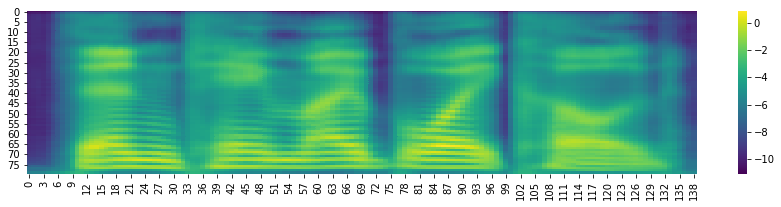

Checkpoint is  126800


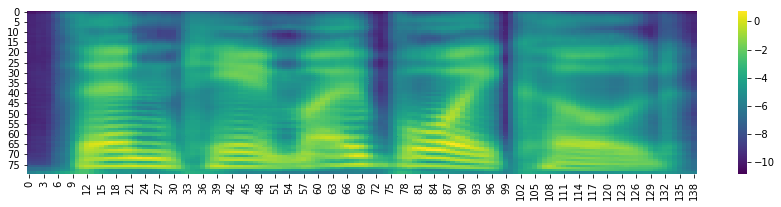

Checkpoint is  150000


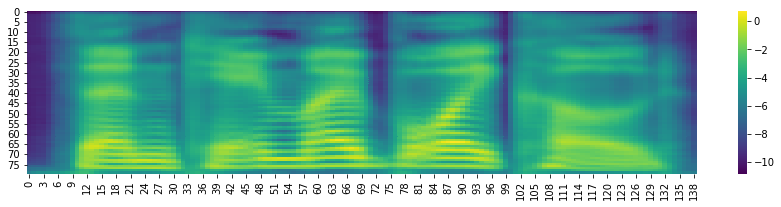

In [110]:
hp = create_hparams_stage()
fp = "/home/fuu/sdb/data/cmu/ppg_mel_pair/bdl_val/file_20_1.txt"

once_test_mel(hp, fp, "/home/fuu/sdb/model/fac_base_cmu/p2m_bdl/checkpoint_75800")
once_test_mel(hp, fp, "/home/fuu/sdb/model/fac_base_cmu/p2m_bdl/checkpoint_83400")
once_test_mel(hp, fp, "/home/fuu/sdb/model/fac_base_cmu/p2m_bdl/checkpoint_92000")
once_test_mel(hp, fp, "/home/fuu/sdb/model/fac_base_cmu/p2m_bdl/checkpoint_104000")
once_test_mel(hp, fp, "/home/fuu/sdb/model/fac_base_cmu/p2m_bdl/checkpoint_126800")
once_test_mel(hp, fp, "/home/fuu/sdb/model/fac_base_cmu/p2m_bdl/checkpoint_150000")

#### 2. 计算PPG

##### 2-0 绘制测试 以/wav/arctic_b0532.wav为例

In [ ]:
# 1. 计算ppg
deps = DependenciesPPG()
teacher_utt_path = "/home/fuu/sdb/fac-via-ppg/data/cmu_us_bdl_arctic/wav/arctic_b0532.wav"
teacher_ppg_cal = get_ppg(teacher_utt_path, deps)

In [ ]:
# mel from model
mel_ac_cal = get_inference(teacher_ppg_cal, tacotron_model, is_clip)
mel_ac_cal_S_0 = mel_ac_cal.cpu().detach().numpy()[0]
mel_ac_cal_tS_0 = mel_ac_cal_S_0[::-1]
np.shape(mel_ac_cal_tS_0)

(80, 371)

In [ ]:
# mel from STFT
mel_au_cal, sr = librosa.load(teacher_utt_path, sr=16000)
mel_au_cal_S_1 = librosa.feature.melspectrogram(mel_au_cal, sr=sr, n_fft=1024, hop_length=160, n_mels=80)
mel_au_cal_logS_1 = librosa.power_to_db(abs(mel_au_cal_S_1[::-1]))
np.shape(mel_au_cal_logS_1)

(80, 370)

In [ ]:
mel_ac_cal_n = (mel_ac_cal_tS_0-np.min(mel_ac_cal_tS_0))/(np.max(mel_ac_cal_tS_0)-np.min(mel_ac_cal_tS_0))
np.shape(mel_ac_cal_n)

(80, 371)

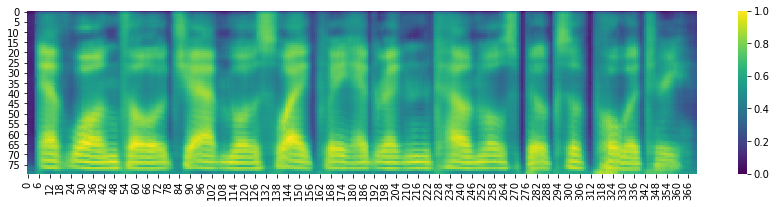

In [ ]:
# model
plt.subplots(figsize=(15,3))
sns.heatmap(mel_ac_cal_n, cmap='viridis')

plt.show()

In [ ]:
mel_au_cal_n = (mel_au_cal_logS_1-np.min(mel_au_cal_logS_1))/(np.max(mel_au_cal_logS_1)-np.min(mel_au_cal_logS_1))
np.shape(mel_au_cal_n)

(80, 370)

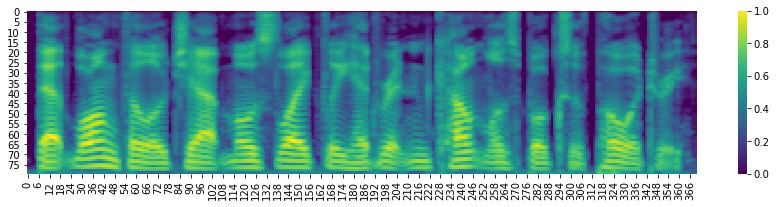

In [ ]:
# STFT
plt.subplots(figsize=(15,3))
sns.heatmap(mel_au_cal_n, cmap='viridis')

plt.show()

##### 2-1 绘制模块化 & 检视bdl_p2m_69800合成效果

In [ ]:
# b0533-b0539
# 未在train和val使用的数据path
path_33 = "/home/fuu/sdb/fac-via-ppg/data/cmu_us_bdl_arctic/wav/arctic_b0533.wav"
path_34 = "/home/fuu/sdb/fac-via-ppg/data/cmu_us_bdl_arctic/wav/arctic_b0534.wav"
path_35 = "/home/fuu/sdb/fac-via-ppg/data/cmu_us_bdl_arctic/wav/arctic_b0535.wav"
path_36 = "/home/fuu/sdb/fac-via-ppg/data/cmu_us_bdl_arctic/wav/arctic_b0536.wav"
path_37 = "/home/fuu/sdb/fac-via-ppg/data/cmu_us_bdl_arctic/wav/arctic_b0537.wav"
path_38 = "/home/fuu/sdb/fac-via-ppg/data/cmu_us_bdl_arctic/wav/arctic_b0538.wav"
path_39 = "/home/fuu/sdb/fac-via-ppg/data/cmu_us_bdl_arctic/wav/arctic_b0539.wav"

In [ ]:
# 载入预测模型
hparams = create_hparams_stage()
checkpoint_path = "/home/fuu/sdb/fac-via-ppg/output/6_28/bdl_p2m/checkpoint_69800"

tacotron_model = load_model(hparams)
tacotron_model.load_state_dict(torch.load(checkpoint_path)['state_dict'])
_ = tacotron_model.eval()

is_clip = False

In [ ]:
# Normalization
def MaxMinNormalization(X, Max, Min):
    X_n = (X - Min) / (Max - Min);
    return X_n;

# Preprocess mel data for plot
def preprocess_mel(path, tacotron_model):
    '''mel from model'''
    is_cal = 1
    if is_cal:
        deps = DependenciesPPG()
        teacher_utt_path = path
        teacher_ppg_cal = get_ppg(teacher_utt_path, deps)
    else:
        # 从磁盘读入
        pass
    mel_ac_cal = get_inference(teacher_ppg_cal, tacotron_model, is_clip)
    mel_ac_cal_S_0 = mel_ac_cal.cpu().detach().numpy()[0]
    mel_ac_cal_tS_0 = mel_ac_cal_S_0[::-1]
    
    model_mel = MaxMinNormalization(mel_ac_cal_tS_0, np.max(mel_ac_cal_tS_0), np.min(mel_ac_cal_tS_0))
    print("Shape of model mel:", np.shape(model_mel))
    
    '''mel from STFT'''
    mel_au_cal, sr = librosa.load(teacher_utt_path, sr=16000)
    mel_au_cal_S_1 = librosa.feature.melspectrogram(mel_au_cal, sr=sr, n_fft=1024, hop_length=160, n_mels=80)
    mel_au_cal_logS_1 = librosa.power_to_db(abs(mel_au_cal_S_1[::-1]))
    
    stft_mel = MaxMinNormalization(mel_au_cal_logS_1, np.max(mel_au_cal_logS_1), np.min(mel_au_cal_logS_1))
    print("Shape of stft mel:", np.shape(stft_mel))
    
    return model_mel, stft_mel

In [ ]:
# plot the Mel fig for model-mel and origin-mel
def draw_mel_pair(mel_list, path):
    fig, ax = plt.subplots(2,1, figsize=(15, 9), sharex=True) 
    titles = ["Model Mel", "STFT Mel"]
    for i, mel in enumerate(mel_list):
        p = sns.heatmap(mel, xticklabels=50, yticklabels=20, cmap='viridis', ax=ax[i]) 
        p.set_yticklabels([80,60,40,20])
        ax[i].set_title(titles[i] + " for " + "<" + path.split("data/")[1] + ">") 
        ax[i].set_ylabel("Channel")
        ax[i].set_xlabel("Frame")

In [ ]:
s33 = path_33.split("data/")
s33

['/home/fuu/sdb/fac-via-ppg/', 'cmu_us_bdl_arctic/wav/arctic_b0533.wav']

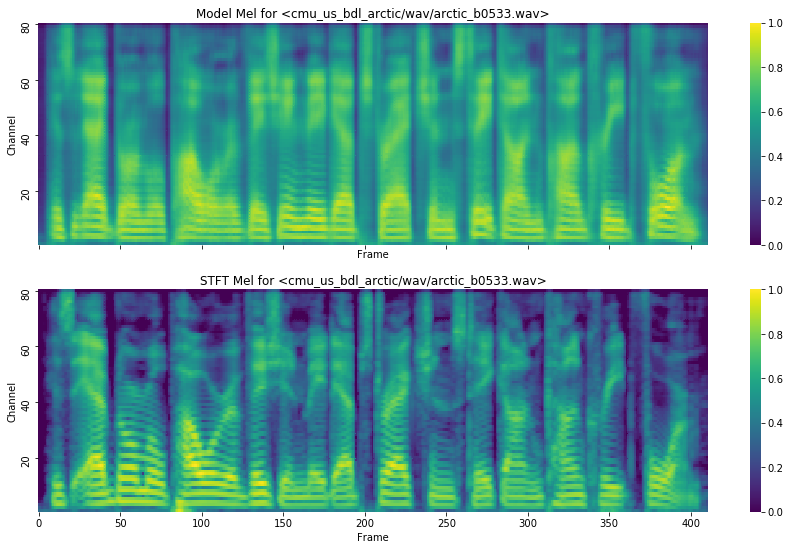

In [ ]:
mm_33, sm_33 = preprocess_mel(path_33, tacotron_model)
draw_mel_pair([mm_33, sm_33], path_33)

Shape of model mel: (80, 296)
Shape of stft mel: (80, 296)


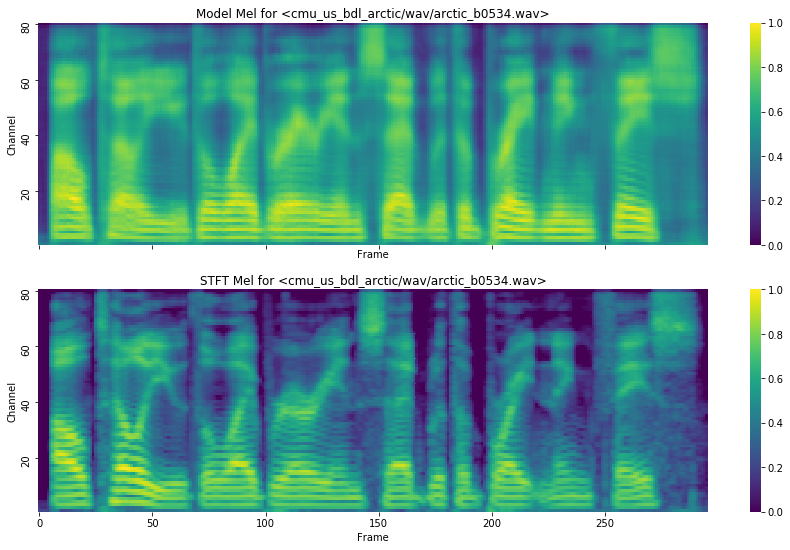

In [ ]:
m34 = preprocess_mel(path_34, tacotron_model)
draw_mel_pair(m34, path_34)

Shape of model mel: (80, 160)
Shape of stft mel: (80, 160)


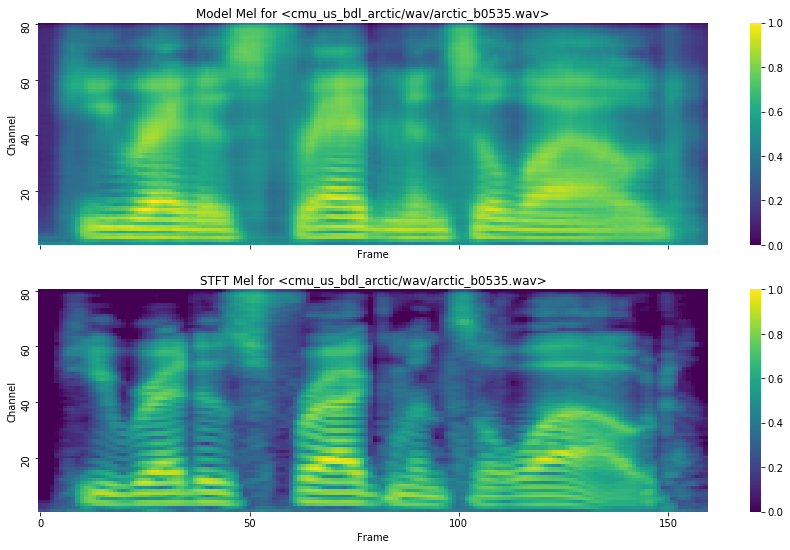

In [ ]:
m35 = preprocess_mel(path_35, tacotron_model)
draw_mel_pair(m35, path_35)

Shape of model mel: (80, 153)
Shape of stft mel: (80, 153)


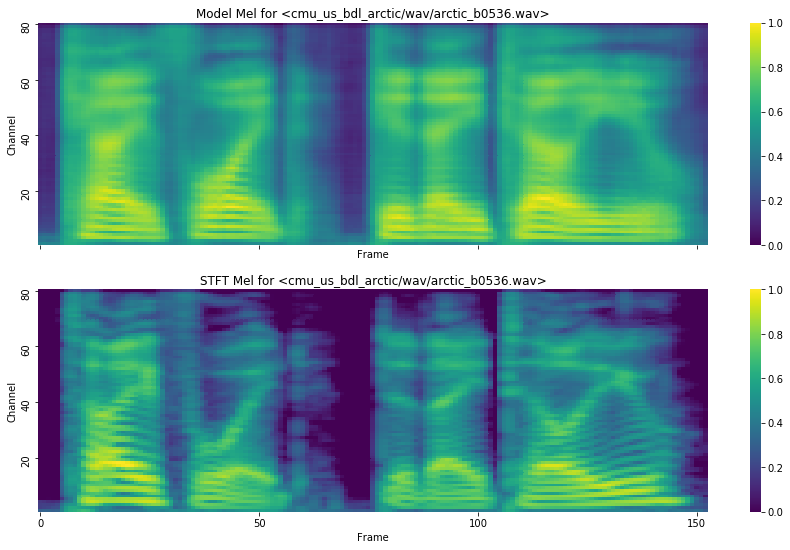

In [ ]:
m36 = preprocess_mel(path_36, tacotron_model)
draw_mel_pair(m36, path_36)

Shape of model mel: (80, 170)
Shape of stft mel: (80, 168)


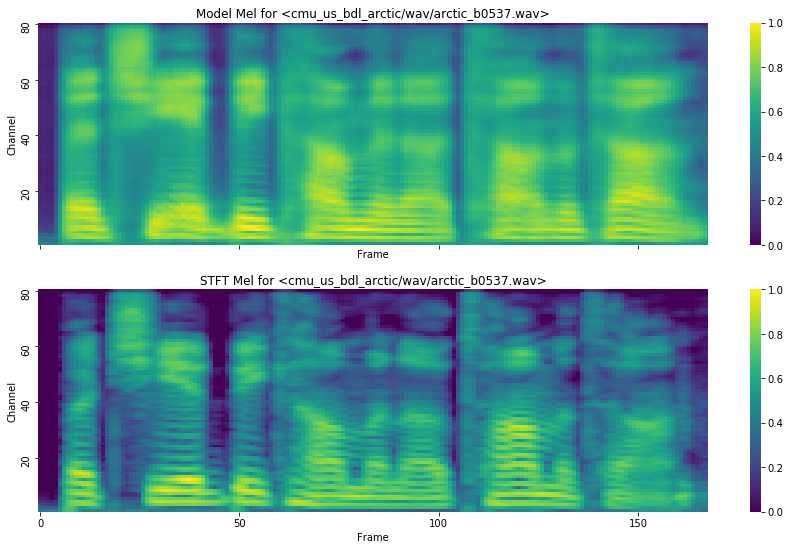

In [ ]:
m37 = preprocess_mel(path_37, tacotron_model)
draw_mel_pair(m37, path_37)

Shape of model mel: (80, 246)
Shape of stft mel: (80, 246)


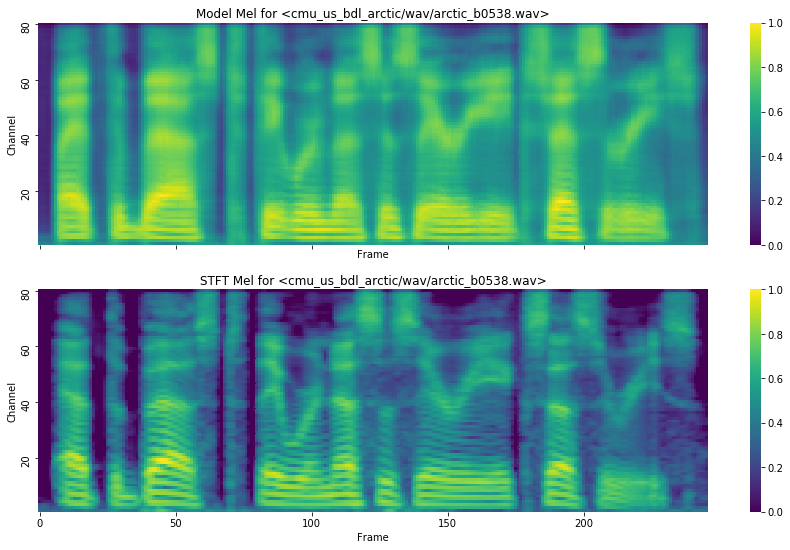

In [ ]:
m38 = preprocess_mel(path_38, tacotron_model)
draw_mel_pair(m38, path_38)

Shape of model mel: (80, 247)
Shape of stft mel: (80, 245)


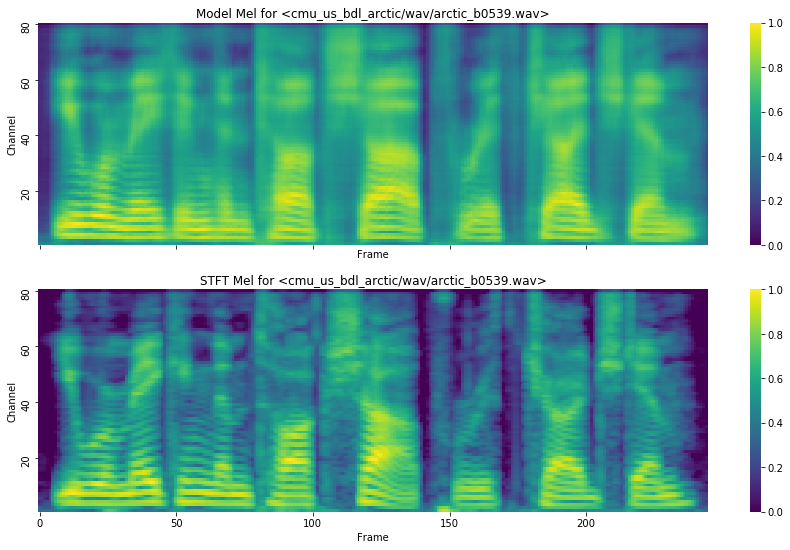

In [ ]:
m39 = preprocess_mel(path_39, tacotron_model)
draw_mel_pair(m39, path_39)

##### 2-3 查看ZHAA&YKWK模型的合成波形态

In [ ]:
hparams_zhaa = create_hparams_stage()
zhaa_path = "/home/fuu/sdb/fac-via-ppg/output/p2m/zhaa_checkpoint_19200"

zhaa_model = load_model(hparams_zhaa)
zhaa_model.load_state_dict(torch.load(zhaa_path)['state_dict'])
_ = zhaa_model.eval()

is_clip = False

Shape of model mel: (80, 412)
Shape of stft mel: (80, 411)


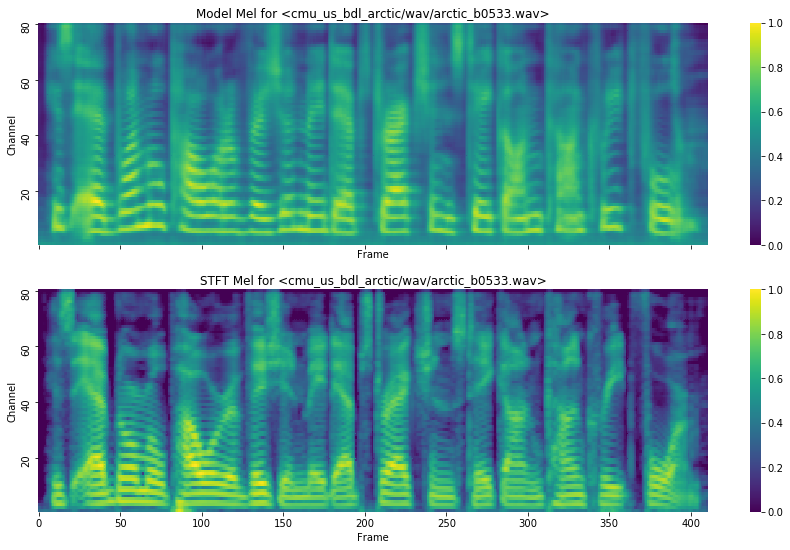

In [ ]:
zhaa33 = preprocess_mel(path_33, zhaa_model)
draw_mel_pair(zhaa33, path_33)

Shape of model mel: (80, 333)
Shape of stft mel: (80, 320)


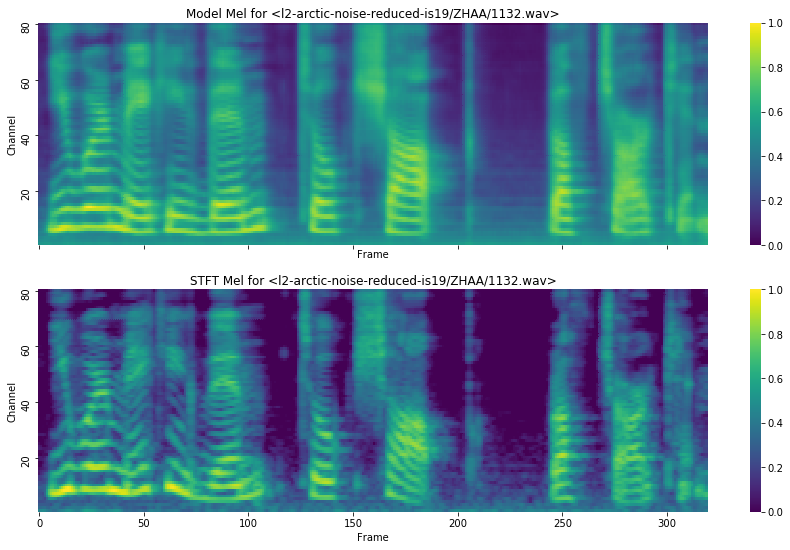

In [ ]:
path_zhaa_1132 = "/home/fuu/sdb/fac-via-ppg/data/l2-arctic-noise-reduced-is19/ZHAA/1132.wav"
zhaa1132 = preprocess_mel(path_zhaa_1132, zhaa_model)
draw_mel_pair(zhaa1132, path_zhaa_1132)

In [ ]:
# YKWK 1132
hparams_ykwk = create_hparams_stage()
ykwk_path = "/home/fuu/sdb/fac-via-ppg/output/p2m/ykwk_checkpoint_30600"

ykwk_model = load_model(hparams_ykwk)
ykwk_model.load_state_dict(torch.load(ykwk_path)['state_dict'])
_ = ykwk_model.eval()

is_clip = False

Shape of model mel: (80, 413)
Shape of stft mel: (80, 413)


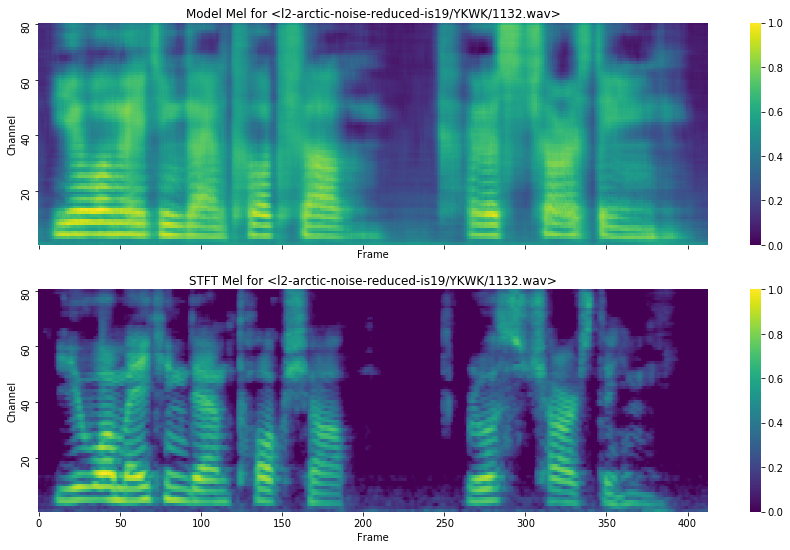

In [ ]:
path_ykwk_1132 = "/home/fuu/sdb/fac-via-ppg/data/l2-arctic-noise-reduced-is19/YKWK/1132.wav"
ykwk1132 = preprocess_mel(path_ykwk_1132, ykwk_model)
draw_mel_pair(ykwk1132, path_ykwk_1132)

##### 2-4 失败模型试验

**问题应该是PPG对于22050Hz的数据取窗的时候出错了。**

In [ ]:
import common.hparams_new as hnew
hparams_lj = hnew.create_hparams_stage()
LJ_path = "/home/fuu/sdb/fac-via-ppg/output/6_20/new_disk_22050_1200_modi/checkpoint_20400"

lj_model = load_model(hparams_lj)
lj_model.load_state_dict(torch.load(zhaa_path)['state_dict'])
_ = lj_model.eval()

is_clip = False

In [ ]:
def pmp(path, tacotron_model):
    '''
    mel from model

    Library:
        from ppg import DependenciesPPG
    '''
    is_cal = 1
    if is_cal:
        deps = DependenciesPPG()
        teacher_utt_path = path
        teacher_ppg_cal = get_ppg(teacher_utt_path, deps)
    else:
        # 从磁盘读入
        pass
    mel_ac_cal = get_inference(teacher_ppg_cal, tacotron_model)
    mel_ac_cal_S_0 = mel_ac_cal.cpu().detach().numpy()[0]
    mel_ac_cal_tS_0 = mel_ac_cal_S_0[::-1]
    
    model_mel = MaxMinNormalization(mel_ac_cal_tS_0, np.max(mel_ac_cal_tS_0), np.min(mel_ac_cal_tS_0))
    print("Shape of model mel:", np.shape(model_mel))
    
    '''mel from STFT'''
    mel_au_cal, sr = librosa.load(teacher_utt_path, sr=22050)
    mel_au_cal_S_1 = librosa.feature.melspectrogram(mel_au_cal, sr=22050, n_fft=1024, hop_length=160, n_mels=80)
    mel_au_cal_logS_1 = librosa.power_to_db(abs(mel_au_cal_S_1[::-1]))
    
    stft_mel = MaxMinNormalization(mel_au_cal_logS_1, np.max(mel_au_cal_logS_1), np.min(mel_au_cal_logS_1))
    print("Shape of stft mel:", np.shape(stft_mel))
    
    return model_mel, stft_mel

Shape of model mel: (80, 934)
Shape of stft mel: (80, 1288)


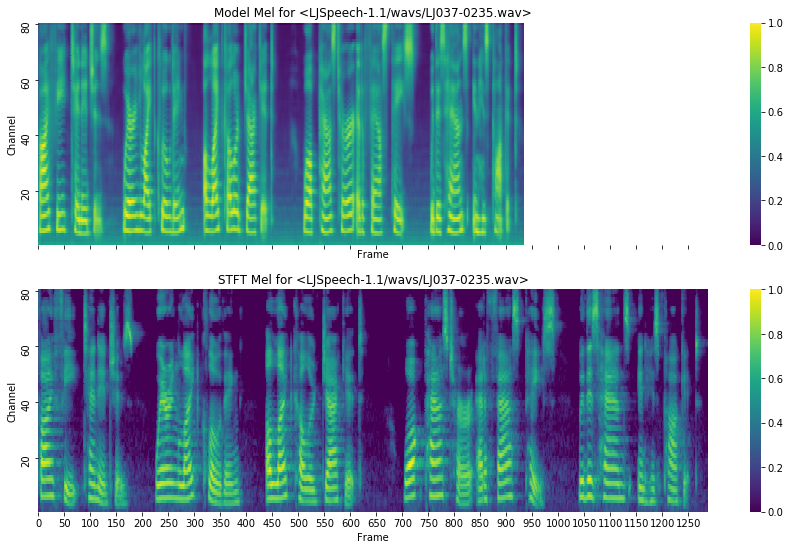

In [ ]:
path_lj_0235 = "/home/fuu/sdb/fac-via-ppg/data/LJSpeech-1.1/wavs/LJ037-0235.wav"
lj0235 = pmp(path_lj_0235, lj_model)
draw_mel_pair(lj0235, path_lj_0235)

### 0628-Ⅱ WaveGlow 模型检视

#### 1. INIT

In [ ]:
# input: 
    # mel 需要STFT
    # waveglow_model 载入
    # denoiser

In [ ]:
# STFT
from waveglow.mel2samp import Mel2Samp
from common.layers import TacotronSTFT

def load_wav_to_torch(full_path):
    """
    Loads wavdata into torch array
    """
    sampling_rate, data = wavfile.read(full_path)
    return torch.from_numpy(data).float(), sampling_rate
def get_mel_for_test(audio):
        audio_norm = audio / MAX_WAV_VALUE
        audio_norm = audio_norm.unsqueeze(0)
        audio_norm = torch.autograd.Variable(audio_norm, requires_grad=False)
        stft = TacotronSTFT(filter_length=1024,
                                 hop_length=160,
                                 win_length=1024,
                                 sampling_rate=16000,
                                 mel_fmin=0.0, mel_fmax=8000.0)
        melspec = stft.mel_spectrogram(audio_norm)
#         melspec = torch.squeeze(melspec, 0)
        return melspec

def mel_via_path(file_path):
#     with open(config_path) as f:
#         data = f.read()
#     data_config = json.loads(data)["data_config"]
# #     mel2samp = Mel2Samp(**data_config)

    audio, sr = load_wav_to_torch(file_path)
    melspectrogram = get_mel_for_test(audio)
    
    return melspectrogram

MAX_WAV_VALUE = 32768.0
config_path = "/home/fuu/sdb/fac-via-ppg/src/waveglow/config_628.json"

In [ ]:
# Load mel from model
def preprocess_model_mel_for_m2w(path, tacotron_model):
    '''mel from model'''
    deps = DependenciesPPG()
    teacher_utt_path = path
    teacher_ppg_cal = get_ppg(teacher_utt_path, deps)
    mel_ac_cal = get_inference(teacher_ppg_cal, tacotron_model, is_clip)
    return mel_ac_cal

In [ ]:
# Load model
def load_waveglow_model(path):
    model = torch.load(path)['model']
    model = model.remove_weightnorm(model)
    model.cuda().eval()
    return model

waveglow_sigma = 0.6

In [ ]:
# Mel to Wave
def waveglow_audio(mel, waveglow, sigma, is_cuda_output=False):
    mel = torch.autograd.Variable(mel.cuda())
    if not is_cuda_output:
        with torch.no_grad():
            audio = 32768 * waveglow.infer(mel, sigma=sigma)[0]
        audio = audio.cpu().numpy()
        audio = audio.astype('int16')
    else:
        with torch.no_grad():
            audio = waveglow.infer(mel, sigma=sigma).cuda()
    return audio

In [ ]:
# Denoiser
from waveglow.denoiser import Denoiser

def load_denoiser(waveglow_path):
    waveglow_for_denoiser = torch.load(waveglow_path)['model']
    waveglow_for_denoiser.cuda()
    denoiser_mode = 'zeros'
    denoiser = Denoiser(waveglow_for_denoiser, mode=denoiser_mode)
    return denoiser
denoiser_strength = 0.005

#### 2. Plot Wave

In [ ]:
m2w_path = "/home/fuu/sdb/fac-via-ppg/output/6_28/bdl_m2w/waveglow_100000"
waveglow_model_100000 = load_waveglow_model(m2w_path)

In [ ]:
denoiser = load_denoiser(m2w_path)

In [ ]:
mel_wav_33 = mel_via_path(path_33)

In [ ]:
mel_wav_33.shape

torch.Size([1, 80, 411])

In [ ]:
# mel to wave
wav_bdl_0533 = waveglow_audio(mel_wav_33, waveglow_model_100000, waveglow_sigma, True)
wav_bdl_0533 = denoiser(wav_bdl_0533, strength=denoiser_strength)[:, 0].cpu().numpy().T

In [ ]:
wav_bdl_0533.T[0].shape

(65760,)

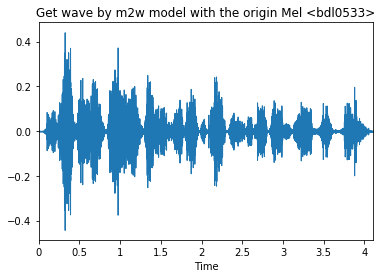

In [ ]:
plt.title("Get wave by m2w model with the origin Mel <bdl0533>")
librosa.display.waveplot(wav_bdl_0533.T[0], sr=16000)

In [ ]:
au_bdl_0533, sr = librosa.load(path_33, sr=16000)

In [ ]:
au_bdl_0533.shape

(65681,)

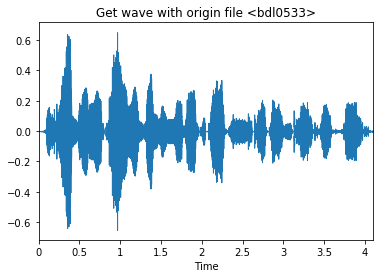

In [ ]:
plt.title("Get wave with origin file <bdl0533>")
librosa.display.waveplot(au_bdl_0533, sr=16000)

In [ ]:
mel_model_wav_33 = preprocess_model_mel_for_m2w(path_33, tacotron_model)

In [ ]:
mel_model_wav_33.shape

torch.Size([1, 80, 411])

In [ ]:
# mel to wave
wav_bdl_0533_model = waveglow_audio(mel_model_wav_33, waveglow_model_100000, waveglow_sigma, True)
wav_bdl_0533_model = denoiser(wav_bdl_0533_model, strength=denoiser_strength)[:, 0].cpu().numpy().T

In [ ]:
wav_bdl_0533_model.shape

(65760, 1)

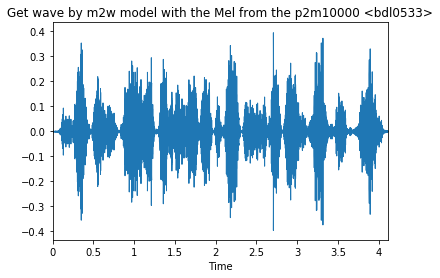

In [ ]:
plt.title("Get wave by m2w model with the Mel from the p2m10000 <bdl0533>")
librosa.display.waveplot(wav_bdl_0533_model.T[0], sr=16000)

#### 3. Output Play

In [ ]:
import IPython.display as ipd

In [ ]:
print("Get wave by m2w model with the origin mel <bdl0533>")
ipd.Audio(data=wav_bdl_0533.T[0], rate=16000)

Get wave by m2w model with the origin mel <bdl0533>


In [ ]:
print("Get wave by m2w model with the Mel from the p2m10000 <bdl0533>")
ipd.Audio(data=wav_bdl_0533_model.T[0], rate=16000)

Get wave by m2w model with the Mel from the p2m10000 <bdl0533>


In [ ]:
print("Get wave by origin file <bdl0533>")
ipd.Audio(filename=path_33, rate=16000)

Get wave by origin file <bdl0533>


### 0704 plotting_utils PPG绘制测试

In [2]:
import sys
sys.path.insert(0, "/home/fuu/sdb/fac-via-ppg/src")
import common.plotting_utils as pu

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
import pickle

with open("/home/fuu/sdb/data/cmu/ppg_mel_pair/bdl_val/merge.txt", "rb") as f:
    data = pickle.load(f)

In [4]:
data[0][0].shape

(139, 5816)

In [8]:
plt_ppg = pu.plot_ppg_to_numpy(data[0][0])
# plt.show(plt_ppg)

In [12]:
plt.

137.57037322816643

In [36]:
phonemes = ["aa", "ae", "ah", "ao", "aw", "ay", "b", "ch", "d", "dh", "eh", "er", "ey", "f", "g", "hh", "ih", 
            "iy", "jh", "k", "l", "m", "n", "ng", "ow", "oy", "p", "r", 
            "s", "sh", "t", "th", "uh", "uw", "v", "w", "y", "z", "zh", "sil"]

In [76]:
def plot_ppg_to_numpy_inline(ppg):
    fig, ax = plt.subplots(figsize=(10, 5))
    im = ax.imshow(ppg, aspect="auto", origin="lower",
                   interpolation='none')
    
    ax.set_yticks(list(range(0, 40)))
    ax.set_yticklabels(phonemes)
    plt.colorbar(im, ax=ax)
    plt.ylabel("Phonemes")
    plt.xlabel("Time")
    plt.tight_layout()
    plt.show()

In [17]:
### 画monophone_ppg
import ppg


monophone_ppg = ppg.compute_monophone_ppg(wav_kaldi, ppg_deps.nnet,
                                                       ppg_deps.lda,
                                                       ppg_deps.monophone_trans,
                                                       self.kaldi_shift)

In [21]:
trans_ppg = ppg_deps.monophone_trans

In [22]:
type(trans_ppg)

_sparse_matrix.SparseMatrix

In [23]:
from kaldi.matrix.sparse import SparseMatrix
from kaldi.matrix import Matrix, Vector
from kaldi.matrix.common import MatrixTransposeType

In [24]:
ppg_M = Matrix(ppg0)

In [25]:
ppg_M.num_rows

139

In [26]:
ppg_deps = ppg.DependenciesPPG()

monophone_ppgs = ppg.reduce_ppg_dim(ppg_M, ppg_deps.monophone_trans)
monophone_ppgs = monophone_ppgs.numpy()

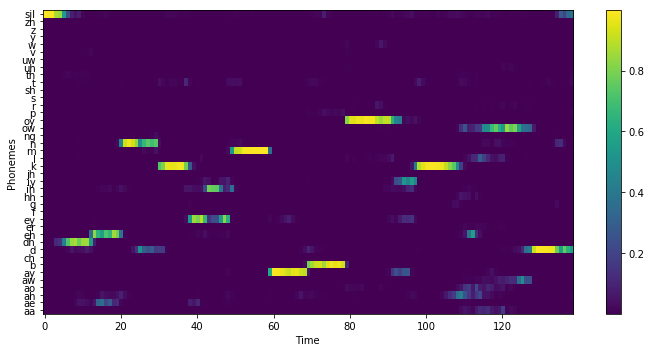

In [77]:
plot_ppg_to_numpy_inline(monophone_ppgs.T)

In [31]:
from custom.my_preprocess import image_ppg, plot_ppg

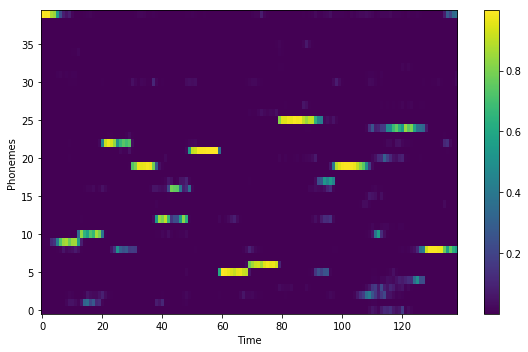

In [34]:
ax, im = image_ppg(data[0][0])
plot_ppg(ax, im)

In [37]:
len(phonemes)

40

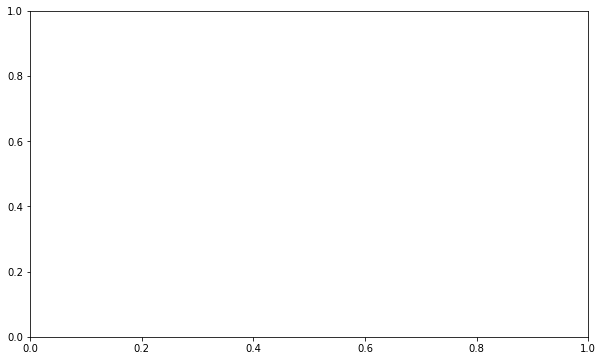

In [66]:
fig, ax = plt.subplots(figsize=(10, 6))

In [61]:
fig.canvas.draw?

Signature: fig.canvas.draw()
Docstring: Draw the figure using the renderer.
File:      ~/miniconda3/envs/ppg-speech/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py
Type:      method


In [67]:
ax.spines?

Type:        OrderedDict
String form: OrderedDict([('left', <matplotlib.spines.Spine object at 0x7f37e15500b8>), ('right', <matplotlib. <...> s.Spine object at 0x7f37e1550630>), ('top', <matplotlib.spines.Spine object at 0x7f37e15e9898>)])
Length:      4
File:        ~/miniconda3/envs/ppg-speech/lib/python3.7/collections/__init__.py
Docstring:   Dictionary that remembers insertion order


### 0714 Tacotron 训练阶段模型比较

#### Tacotron 训练阶段模型mel比较

In [3]:
sys.path

import pickle
import numpy as np

from common.hparams_628 import create_hparams_stage
from script.train_ppg2mel_628 import load_model
import torch

import matplotlib.pyplot as plt
import librosa.display
import librosa

from common.hparams_628 import create_hparams_stage
from script.train_ppg2mel_628 import load_model
import torch

from ppg import DependenciesPPG
from scipy.io import wavfile
from common import feat
from common import ppg

from custom.taco_val_proc import PPG_via_pickle, Taco_Model

%matplotlib inline

import importlib
import custom.taco_val_proc as tvp

import os

In [142]:
importlib.reload(custom.taco_val_proc)

<module 'custom.taco_val_proc' from '/home/fuu/sdb/fac-via-ppg/src/custom/taco_val_proc.py'>

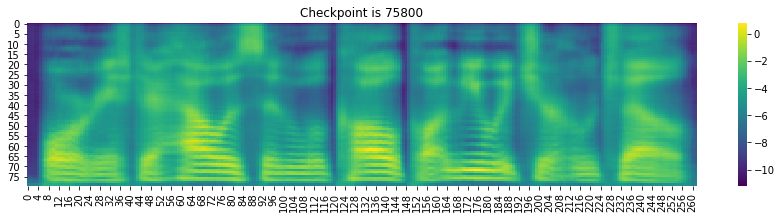

In [26]:
hparams = create_hparams_stage()

fp = "/home/fuu/sdb/data/cmu/ppg_mel_pair/bdl_val/file_20_1.txt"
mp = "/home/fuu/sdb/model/fac_base_cmu/p2m_bdl/checkpoint_75800"
wp = ""

tm = tvp.Taco_Model(mp, hparams)
pp = tvp.PPG_via_pickle(fp, tm.model, index=1, mp=tm.path)
pp.plot_mel()

In [31]:
mp_list = ["/home/fuu/sdb/model/fac_base_cmu/p2m_bdl/checkpoint_75800", "/home/fuu/sdb/model/fac_base_cmu/p2m_bdl/checkpoint_85800", 
 "/home/fuu/sdb/model/fac_base_cmu/p2m_bdl/checkpoint_95800", "/home/fuu/sdb/model/fac_base_cmu/p2m_bdl/checkpoint_105800", 
 "/home/fuu/sdb/model/fac_base_cmu/p2m_bdl/checkpoint_115800", "/home/fuu/sdb/model/fac_base_cmu/p2m_bdl/checkpoint_125800",
 "/home/fuu/sdb/model/fac_base_cmu/p2m_bdl/checkpoint_135800", "/home/fuu/sdb/model/fac_base_cmu/p2m_bdl/checkpoint_145800"]

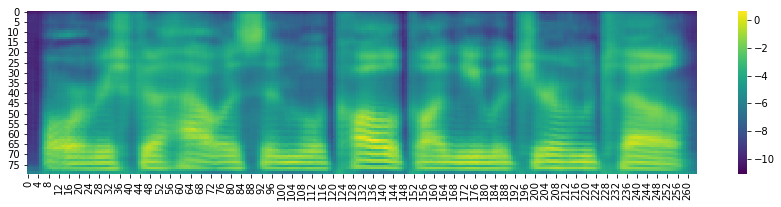

In [ ]:
# logS_0 = librosa.power_to_db(abs(S_0[::-1]))
# 生成的mel不需要power_to_db

plt.subplots(figsize=(15,3))
sns.heatmap(S_0[::-1], cmap='viridis')

plt.show()
plt.close()

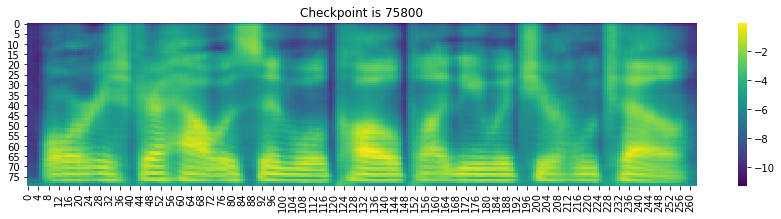

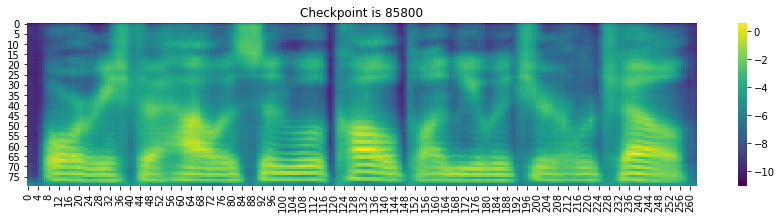

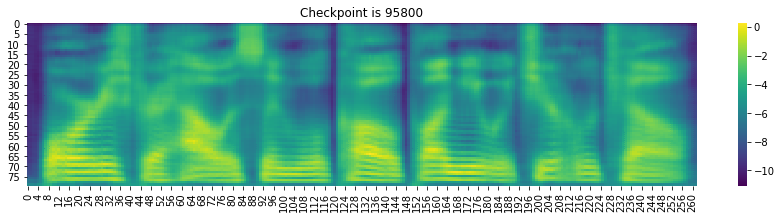

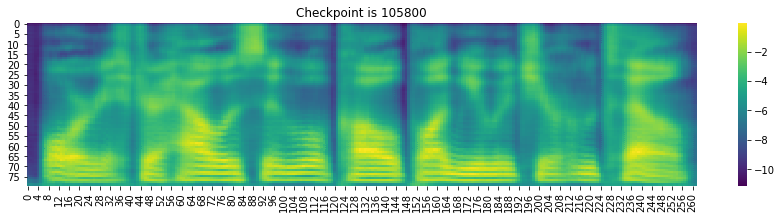

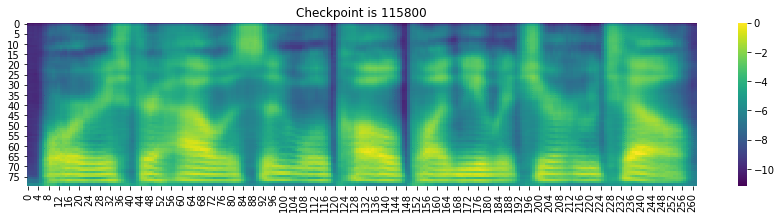

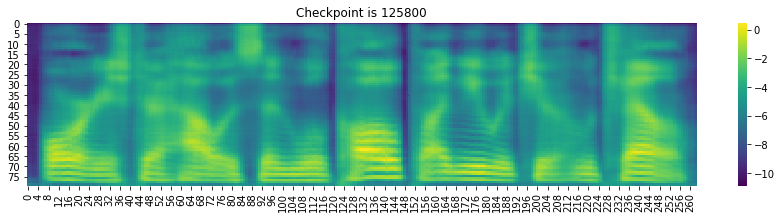

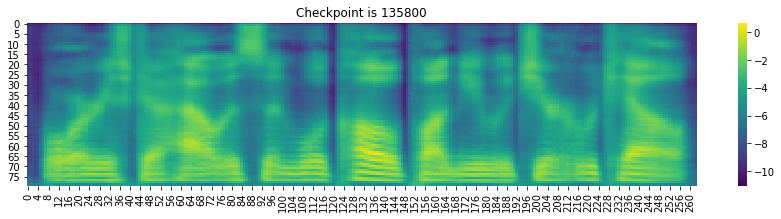

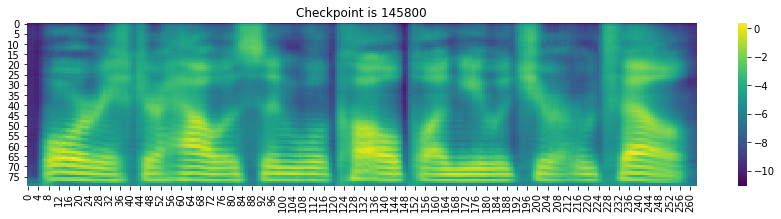

In [34]:
hparams = create_hparams_stage()
fp = "/home/fuu/sdb/data/cmu/ppg_mel_pair/bdl_val/file_20_1.txt"

for m in mp_list:
    t = tvp.Taco_Model(m, hparams)
    p = tvp.PPG_via_pickle(fp, tm.model, index=1, mp=t.path)
    p.plot_mel()

In [ ]:
# 使用计算的PPGs
/home/fuu/sdb/data/cmu/cmu_us_bdl_arctic/wav/arctic_b0539.wav

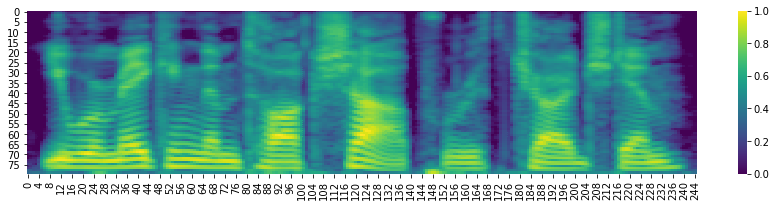

In [38]:
deps = DependenciesPPG()
wp = "/home/fuu/sdb/data/cmu/cmu_us_bdl_arctic/wav/arctic_b0539.wav"
pw_s = tvp.PPG_via_wav(deps, wp, is_stft=True)
pw_s.plot_mel(pw_s.n_mel[::-1])

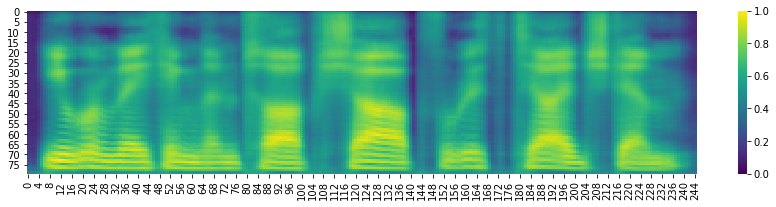

In [40]:
pw_m = tvp.PPG_via_wav(deps, wp, tm.model)
pw_m.plot_mel(pw_m.n_mel[::-1])

In [41]:
mel_via_model = []
for m in mp_list:
    t = tvp.Taco_Model(m, hparams)
    pw = tvp.PPG_via_wav(deps, wp, t.model)
    mel_via_model.append(pw.n_mel)

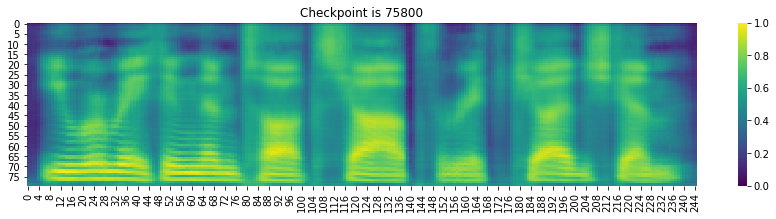

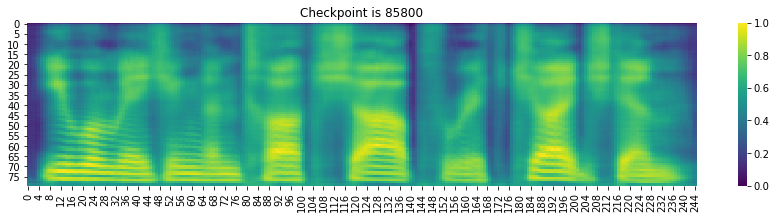

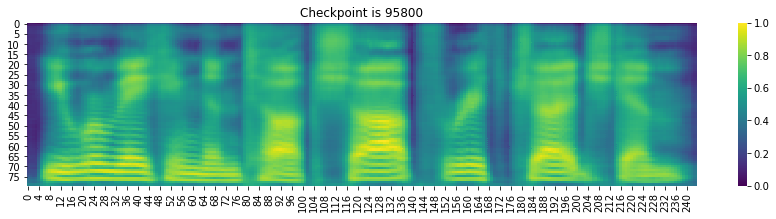

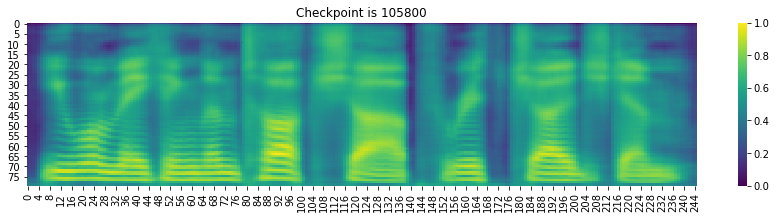

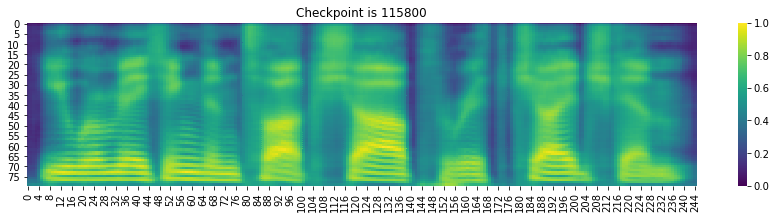

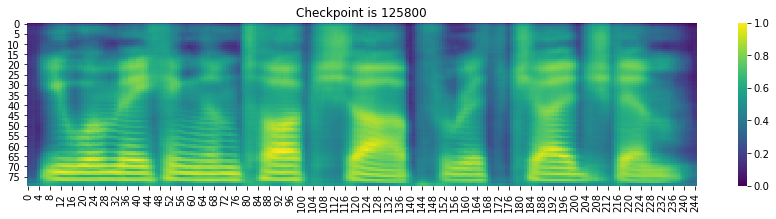

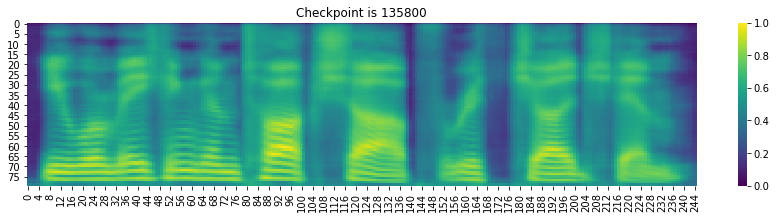

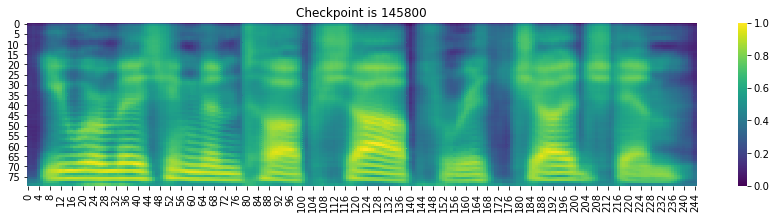

In [136]:
pw_m = tvp.PPG_via_wav(deps, wp, is_stft=True)
for i, mel in enumerate(mel_via_model):
    pw_m.plot_mel(mel[::-1], mp_list[i], save_path="/home/fuu/sdb/temp/fig/mel_714/")

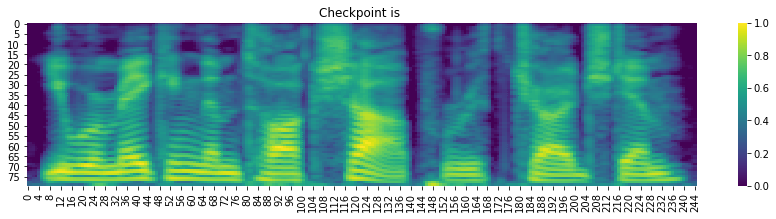

In [144]:
pw_m = tvp.PPG_via_wav(deps, wp, is_stft=True)
pw_m.plot_mel(pw_s.n_mel[::-1], save_path="/home/fuu/sdb/temp/fig/mel_714/origin_")

In [138]:
"".split(sep="_c")

['']

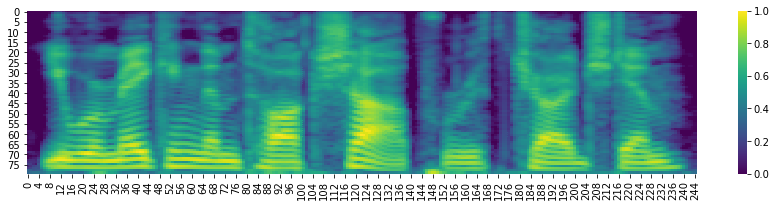

In [38]:
deps = DependenciesPPG()
wp = "/home/fuu/sdb/data/cmu/cmu_us_bdl_arctic/wav/arctic_b0539.wav"
pw_s = tvp.PPG_via_wav(deps, wp, is_stft=True)
pw_s.plot_mel(pw_s.n_mel[::-1])

#### 合成波比较

In [ ]:
# 测试合成 使用pretrain模型
/home/fuu/sdb/model/fac-pretrain/interspeech19-stage/ppg2speech-si-am-si-tacotron-clb2zhaa-final/waveglow_277500 # female
/home/fuu/sdb/model/fac-pretrain/interspeech19-stage/ppg2speech-si-am-si-tacotron-bdl2ykwk-final/waveglow_270000 # male

In [43]:
import custom.my_preprocess as mypre

In [47]:
importlib.reload(mypre)

<module 'custom.my_preprocess' from '/home/fuu/sdb/fac-via-ppg/src/custom/my_preprocess.py'>

In [44]:
m2w_f = "/home/fuu/sdb/model/fac-pretrain/interspeech19-stage/ppg2speech-si-am-si-tacotron-clb2zhaa-final/waveglow_277500"
m2w_m = "/home/fuu/sdb/model/fac-pretrain/interspeech19-stage/ppg2speech-si-am-si-tacotron-bdl2ykwk-final/waveglow_270000"

In [48]:
wgmf = mypre.load_waveglow_model(m2w_f) 
wgmm = mypre.load_waveglow_model(m2w_m)

/home/fuu/miniconda3/envs/ppg-speech/lib/python3.7/site-packages/torch/serialization.py:454: SourceChangeWarning: source code of class 'torch.nn.modules.conv.ConvTranspose1d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/fuu/miniconda3/envs/ppg-speech/lib/python3.7/site-packages/torch/serialization.py:454: SourceChangeWarning: source code of class 'torch.nn.modules.container.ModuleList' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/fuu/miniconda3/envs/ppg-speech/lib/python3.7/site-packages/torch/serialization.py:454: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv1d' has changed. you can r

In [49]:
denoiserf = mypre.load_denoiser(m2w_f)
denoiserm = mypre.load_denoiser(m2w_m)

/home/fuu/miniconda3/envs/ppg-speech/lib/python3.7/site-packages/torch/serialization.py:454: SourceChangeWarning: source code of class 'torch.nn.modules.conv.ConvTranspose1d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/fuu/miniconda3/envs/ppg-speech/lib/python3.7/site-packages/torch/serialization.py:454: SourceChangeWarning: source code of class 'torch.nn.modules.container.ModuleList' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/fuu/miniconda3/envs/ppg-speech/lib/python3.7/site-packages/torch/serialization.py:454: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv1d' has changed. you can r

AttributeError: 'ConvTranspose1d' object has no attribute 'padding_mode'

In [51]:
# wav data
wp = "/home/fuu/sdb/data/cmu/cmu_us_bdl_arctic/wav/arctic_b0539.wav"

In [54]:
# stft mel
ms = mypre.get_mel_for_test(wp)

ms.shape

torch.Size([1, 80, 245])

In [69]:
mel11 = np.array([mel_via_model[1]])
mel11.shape

# 把np数组转换成可用的torch形式
mel11 = torch.from_numpy(mel11).float()
# mel11 = torch.autograd.Variable(mel11.cuda())
mel11.shape

In [75]:
# 使用之前转换好的正规化的mel
# 失败
mm_cuda = []
for mm in mel_via_model:
    mm = np.array([mm])
    mm = torch.from_numpy(mm).float()
#     mm = torch.autograd.Variable(mm.cuda())
    mm_cuda.append(mm)

In [77]:
mm_cuda[0].shape

torch.Size([1, 80, 245])

In [85]:
# 再调用一遍合成mel
mel_list_m2w=[]
for m in mp_list:
    tm = tvp.Taco_Model(m, hparams)
    mel_c = mypre.preprocess_model_mel_for_m2w(wp, tm.model)
    mel_list_m2w.append(mel_c)

In [86]:
mel_list_m2w[1].shape

torch.Size([1, 80, 246])

In [97]:
# Debug 一个关于pytorch的bug
# AttributeError: 'ConvTranspose1d' object has no attribute 'padding_mode'


from waveglow.glow import WaveGlow
import json
from waveglow.denoiser import Denoiser

config_file_path = '/home/fuu/sdb/fac-via-ppg/src/waveglow/config.json'
with open(config_file_path) as f:
    data = f.read()
config = json.loads(data)
waveglow_config = config["waveglow_config"]

model_state_dict = torch.load(m2w_m)['model'].state_dict()
modelm = WaveGlow(**waveglow_config)
modelm.load_state_dict(model_state_dict)
modelm.cuda()

# waveglow_for_denoiser = torch.load(waveglow_path)['model']
# waveglow_for_denoiser.cuda()
denoiser_mode = 'zeros'
denoiser = Denoiser(modelm, mode=denoiser_mode)

modelm.cuda().eval()

WaveGlow(
  (upsample): ConvTranspose1d(80, 80, kernel_size=(1024,), stride=(160,))
  (WN): ModuleList(
    (0): WN(
      (in_layers): ModuleList(
        (0): Conv1d(256, 512, kernel_size=(3,), stride=(1,), padding=(1,))
        (1): Conv1d(256, 512, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,))
        (2): Conv1d(256, 512, kernel_size=(3,), stride=(1,), padding=(4,), dilation=(4,))
        (3): Conv1d(256, 512, kernel_size=(3,), stride=(1,), padding=(8,), dilation=(8,))
        (4): Conv1d(256, 512, kernel_size=(3,), stride=(1,), padding=(16,), dilation=(16,))
        (5): Conv1d(256, 512, kernel_size=(3,), stride=(1,), padding=(32,), dilation=(32,))
        (6): Conv1d(256, 512, kernel_size=(3,), stride=(1,), padding=(64,), dilation=(64,))
        (7): Conv1d(256, 512, kernel_size=(3,), stride=(1,), padding=(128,), dilation=(128,))
      )
      (res_skip_layers): ModuleList(
        (0): Conv1d(256, 512, kernel_size=(1,), stride=(1,))
        (1): Conv1d(256, 512, k

In [114]:
# Debug 一个关于pytorch的bug
# AttributeError: 'ConvTranspose1d' object has no attribute 'padding_mode'


from waveglow.glow import WaveGlow
import json
from waveglow.denoiser import Denoiser

config_file_path = '/home/fuu/sdb/fac-via-ppg/src/waveglow/config.json'
with open(config_file_path) as f:
    data = f.read()
config = json.loads(data)
waveglow_config = config["waveglow_config"]

model_state_dict = torch.load(m2w_f)['model'].state_dict()
modelf = WaveGlow(**waveglow_config)
modelf.load_state_dict(model_state_dict)
modelf.cuda()

# waveglow_for_denoiser = torch.load(waveglow_path)['model']
# waveglow_for_denoiser.cuda()
denoiser_mode = 'zeros'
denoiser = Denoiser(modelf, mode=denoiser_mode)

modelf.cuda().eval()

/home/fuu/miniconda3/envs/ppg-speech/lib/python3.7/site-packages/torch/serialization.py:454: SourceChangeWarning: source code of class 'torch.nn.modules.conv.ConvTranspose1d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/fuu/miniconda3/envs/ppg-speech/lib/python3.7/site-packages/torch/serialization.py:454: SourceChangeWarning: source code of class 'torch.nn.modules.container.ModuleList' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/home/fuu/miniconda3/envs/ppg-speech/lib/python3.7/site-packages/torch/serialization.py:454: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv1d' has changed. you can r

WaveGlow(
  (upsample): ConvTranspose1d(80, 80, kernel_size=(1024,), stride=(160,))
  (WN): ModuleList(
    (0): WN(
      (in_layers): ModuleList(
        (0): Conv1d(256, 512, kernel_size=(3,), stride=(1,), padding=(1,))
        (1): Conv1d(256, 512, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,))
        (2): Conv1d(256, 512, kernel_size=(3,), stride=(1,), padding=(4,), dilation=(4,))
        (3): Conv1d(256, 512, kernel_size=(3,), stride=(1,), padding=(8,), dilation=(8,))
        (4): Conv1d(256, 512, kernel_size=(3,), stride=(1,), padding=(16,), dilation=(16,))
        (5): Conv1d(256, 512, kernel_size=(3,), stride=(1,), padding=(32,), dilation=(32,))
        (6): Conv1d(256, 512, kernel_size=(3,), stride=(1,), padding=(64,), dilation=(64,))
        (7): Conv1d(256, 512, kernel_size=(3,), stride=(1,), padding=(128,), dilation=(128,))
      )
      (res_skip_layers): ModuleList(
        (0): Conv1d(256, 512, kernel_size=(1,), stride=(1,))
        (1): Conv1d(256, 512, k

In [98]:
# mel to wave

wav_or_m = mypre.waveglow_audio(ms, modelm, mypre.waveglow_sigma, True)
wav_or_m = denoiser(wav_or_m, strength=mypre.denoiser_strength)[:, 0].cpu().numpy().T
wav_or_m.T[0].shape

(39200,)

In [100]:
wav758m = mypre.waveglow_audio(mel_list_m2w[0], modelm, mypre.waveglow_sigma, True)
wav758m = denoiser(wav758m, strength=mypre.denoiser_strength)[:, 0].cpu().numpy().T
wav758m.T[0].shape

(39200,)

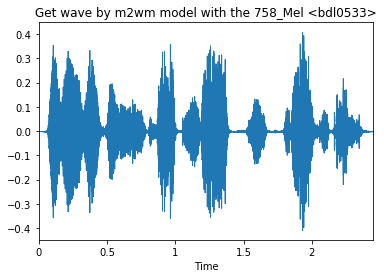

In [102]:
plt.title("Get wave by m2wm model with the 758_Mel <bdl0533>")
librosa.display.waveplot(wav758m.T[0], sr=16000)

In [31]:
mp_list = ["/home/fuu/sdb/model/fac_base_cmu/p2m_bdl/checkpoint_75800", "/home/fuu/sdb/model/fac_base_cmu/p2m_bdl/checkpoint_85800", 
 "/home/fuu/sdb/model/fac_base_cmu/p2m_bdl/checkpoint_95800", "/home/fuu/sdb/model/fac_base_cmu/p2m_bdl/checkpoint_105800", 
 "/home/fuu/sdb/model/fac_base_cmu/p2m_bdl/checkpoint_115800", "/home/fuu/sdb/model/fac_base_cmu/p2m_bdl/checkpoint_125800",
 "/home/fuu/sdb/model/fac_base_cmu/p2m_bdl/checkpoint_135800", "/home/fuu/sdb/model/fac_base_cmu/p2m_bdl/checkpoint_145800"]

In [103]:
# 由YKWK合成的wav
wdata = []
for m in mel_list_m2w:
    wavtm = mypre.waveglow_audio(m, modelm, mypre.waveglow_sigma, True)
    wavtm = denoiser(wavtm, strength=mypre.denoiser_strength)[:, 0].cpu().numpy().T
    wdata.append(wavtm)

In [107]:
wdata[0].shape

(39200, 1)

In [115]:
# 由ZHAA合成的wav
wdata_f = []
for m in mel_list_m2w:
    wavtf = mypre.waveglow_audio(m, modelf, mypre.waveglow_sigma, True)
    wavtf = denoiser(wavtf, strength=mypre.denoiser_strength)[:, 0].cpu().numpy().T
    wdata_f.append(wavtf)

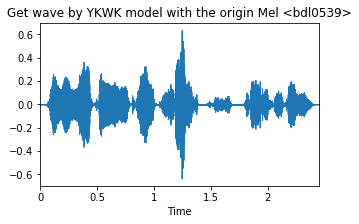

In [116]:
#ykwk
plt.figure(figsize=(5,3))
plt.title("Get wave by YKWK model with the origin Mel <bdl0539>")
librosa.display.waveplot(wav_or_m.T[0], sr=16000)
plt.savefig("/home/fuu/sdb/temp/fig/origin_ykwk_wav.png")

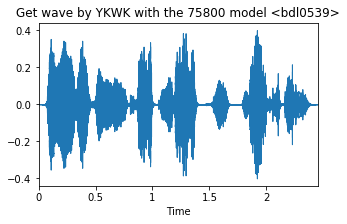

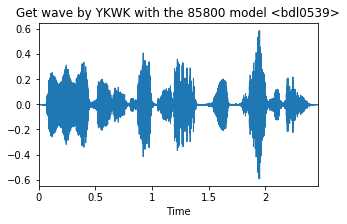

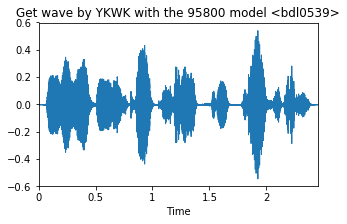

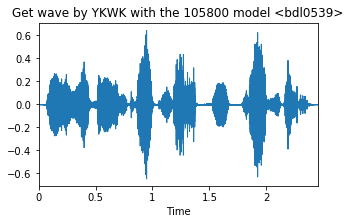

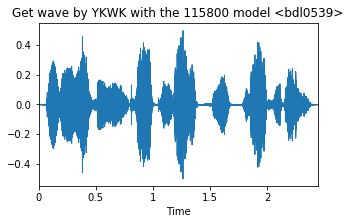

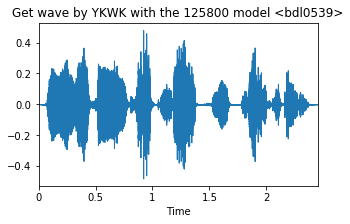

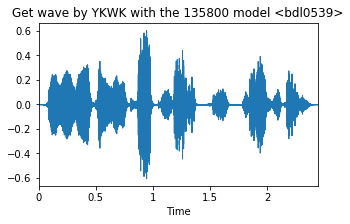

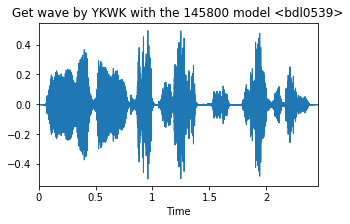

In [113]:
# ykwk
for mp, w in zip(mp_list, wdata):
    plt.figure(figsize=(5,3))
    plt.title("Get wave by YKWK with the " + mp.split(sep="_")[-1] + " model <bdl0539>")
    librosa.display.waveplot(w.T[0], sr=16000)
    plt.savefig("/home/fuu/sdb/temp/fig/" + mp.split(sep="_")[-1] + 't_ykwk_wav.png')

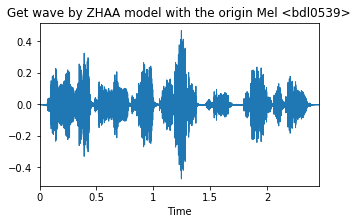

In [117]:
# zhaa
wav_or_f = mypre.waveglow_audio(ms, modelf, mypre.waveglow_sigma, True)
wav_or_f = denoiser(wav_or_f, strength=mypre.denoiser_strength)[:, 0].cpu().numpy().T
wav_or_f.T[0].shape

plt.figure(figsize=(5,3))
plt.title("Get wave by ZHAA model with the origin Mel <bdl0539>")
librosa.display.waveplot(wav_or_f.T[0], sr=16000)
plt.savefig("/home/fuu/sdb/temp/fig/origin_zhaa_wav.png")

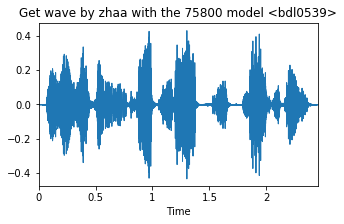

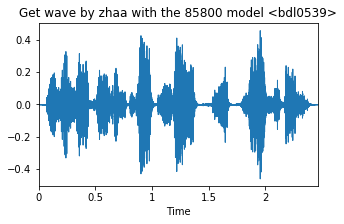

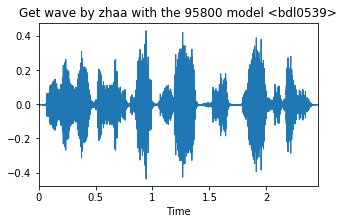

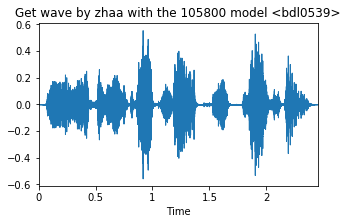

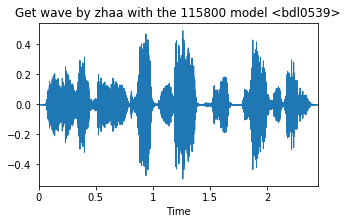

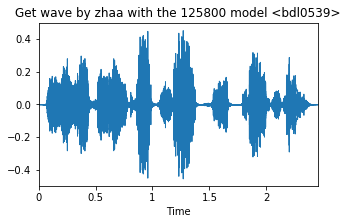

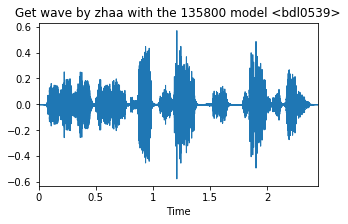

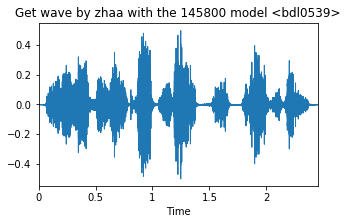

In [118]:
# zhaa
for mp, w in zip(mp_list, wdata_f):
    plt.figure(figsize=(5,3))
    plt.title("Get wave by zhaa with the " + mp.split(sep="_")[-1] + " model <bdl0539>")
    librosa.display.waveplot(w.T[0], sr=16000)
    plt.savefig("/home/fuu/sdb/temp/fig/" + mp.split(sep="_")[-1] + 't_zhaa_wav.png')

In [119]:
for mp, w in zip(mp_list, wdata_f):
    librosa.output.write_wav("/home/fuu/sdb/temp/wav/" + mp.split(sep="_")[-1] + 't_zhaa.wav', w, 16000)

In [124]:
librosa.output.write_wav("/home/fuu/sdb/temp/wav/" + 'origin_zhaa.wav', wav_or_f, 16000)
librosa.output.write_wav("/home/fuu/sdb/temp/wav/" + 'origin_ykwk.wav', wav_or_m, 16000)

In [120]:
import IPython.display as ipd

In [123]:
ipd.Audio("/home/fuu/sdb/temp/wav/origin_zhaa.wav")

In [125]:
ipd.Audio("/home/fuu/sdb/temp/wav/origin_ykwk.wav")

In [127]:
ipd.Audio(wp)

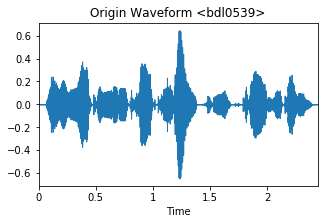

In [128]:
plt.figure(figsize=(5,3))
plt.title("Origin Waveform <bdl0539>")
x, sr = librosa.load(wp)
librosa.display.waveplot(x, sr)
plt.savefig("/home/fuu/sdb/temp/fig/origin_wav.png")

In [130]:
for mp, w in zip(mp_list, wdata):
    librosa.output.write_wav("/home/fuu/sdb/temp/wav/" + mp.split(sep="_")[-1] + 't_ykwk.wav', w, 16000)

In [131]:
for wav in os.listdir("/home/fuu/sdb/temp/wav/"):
    print("/home/fuu/sdb/temp/wav/" + wav)
    ipd.Audio("/home/fuu/sdb/temp/wav/" + wav)

/home/fuu/sdb/temp/wav/105800t_ykwk.wav
/home/fuu/sdb/temp/wav/105800t_zhaa.wav
/home/fuu/sdb/temp/wav/115800t_ykwk.wav
/home/fuu/sdb/temp/wav/115800t_zhaa.wav
/home/fuu/sdb/temp/wav/125800t_ykwk.wav
/home/fuu/sdb/temp/wav/125800t_zhaa.wav
/home/fuu/sdb/temp/wav/135800t_ykwk.wav
/home/fuu/sdb/temp/wav/135800t_zhaa.wav
/home/fuu/sdb/temp/wav/145800t_ykwk.wav
/home/fuu/sdb/temp/wav/145800t_zhaa.wav
/home/fuu/sdb/temp/wav/75800t_ykwk.wav
/home/fuu/sdb/temp/wav/75800t_zhaa.wav
/home/fuu/sdb/temp/wav/85800t_ykwk.wav
/home/fuu/sdb/temp/wav/85800t_zhaa.wav
/home/fuu/sdb/temp/wav/95800t_ykwk.wav
/home/fuu/sdb/temp/wav/95800t_zhaa.wav
/home/fuu/sdb/temp/wav/arctic_b0539.wav
/home/fuu/sdb/temp/wav/origin_ykwk.wav
/home/fuu/sdb/temp/wav/origin_zhaa.wav
